In [ ]:
!pip install tensorflow
!pip install numpy
!pip install matplotlib
import tensorflow as tf # print(tf.__version__) 2.17.1
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="keras")

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("msambare/fer2013")

print("Path to dataset files:", path)

In [ ]:
# BAD

import os
import numpy as np
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import math
import time

# Dataset paths
data_dir = "/kaggle/input/fer2013"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

# Parameters
img_size = 48
input_shape = (img_size, img_size, 1)  # For grayscale images
batch_size = 32
epochs = 100

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    color_mode="grayscale",  # Set to grayscale
    class_mode="categorical",
    subset="training"
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    color_mode="grayscale",  # Set to grayscale
    class_mode="categorical",
    subset="validation"
)

# Test data generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    color_mode="grayscale",  # Set to grayscale
    class_mode="categorical",
    shuffle=False
)

# Class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

# Learning rate scheduler
def cosine_annealing(epoch, lr):
    initial_lr = 0.0005
    return initial_lr * (1 + math.cos(math.pi * epoch / epochs)) / 2

lr_scheduler = LearningRateScheduler(cosine_annealing)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6)

# Model setup
base_model = EfficientNetB0(include_top=False, input_tensor=Input(shape=input_shape), weights=None)
base_model.trainable = True

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(len(train_generator.class_indices), activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_accuracy", mode="max")

# Model training
start_time = time.time()
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[early_stopping, model_checkpoint, lr_scheduler, reduce_lr]
)
end_time = time.time()

print(f"Training Time: {end_time - start_time:.2f} seconds")

# Save the trained model
model.save("final_emotion_model.keras")

# Evaluate on test data
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Confusion matrix and classification report
predictions = np.argmax(model.predict(test_generator), axis=-1)
true_labels = test_generator.classes
cm = confusion_matrix(true_labels, predictions)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(true_labels, predictions, target_names=test_generator.class_indices.keys()))

# Plot accuracy and loss
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Training and Validation Loss")

plt.show()

In [ ]:
# Test saved model on test images
saved_model = keras.models.load_model("final_emotion_model.keras")
class_labels = list(test_generator.class_indices.keys())

# Test each class
test_dir_classes = [os.path.join(test_dir, class_name) for class_name in class_labels]

for class_name, class_path in zip(class_labels, test_dir_classes):
    if os.path.exists(class_path):
        test_images = os.listdir(class_path)
        print(f"\nTesting images for class: {class_name}")
        for img_name in test_images[:5]:  # Test on up to 5 images per class
            img_path = os.path.join(class_path, img_name)
            img = keras.preprocessing.image.load_img(img_path, target_size=(img_size, img_size), color_mode="grayscale")
            img_array = keras.preprocessing.image.img_to_array(img) / 255.0
            img_array = np.expand_dims(img_array, axis=0)

            prediction = saved_model.predict(img_array)
            predicted_class = class_labels[np.argmax(prediction)]
            confidence = np.max(prediction)

            plt.imshow(img, cmap="gray")
            plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence:.2f}")
            plt.axis("off")
            plt.show()

In [ ]:
#BEST ONE

import os
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau

# Dataset paths (confirm directory names match your actual dataset structure)
data_dir = "/kaggle/input/combined-image-dataset/affactnetfer2013"
train_dir = os.path.join(data_dir, "Train")  # Case-sensitive!
test_dir = os.path.join(data_dir, "Test")

# Parameters
img_size = 96
batch_size = 64
epochs = 100

# ==============================================
# 1. Data Pipeline with Augmentation
# ==============================================
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.3,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode="categorical",
    subset="training"
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode="categorical",
    subset="validation"
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode="categorical",
    shuffle=False
)

# ==============================================
# 2. Class Imbalance Handling
# ==============================================
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

# ==============================================
# 3. Model Architecture
# ==============================================
input_tensor = Input(shape=(img_size, img_size, 3))
base_model = EfficientNetB0(include_top=False, weights="imagenet", input_tensor=input_tensor)
base_model.trainable = True  # Fine-tune all layers

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01))(x)
x = Dropout(0.4)(x)
output = Dense(len(train_generator.class_indices), activation="softmax")(x)

model = Model(inputs=input_tensor, outputs=output)

# ==============================================
# 4. Focal Loss (Optional - Replace if needed)
# ==============================================
def focal_loss(gamma=2.0, alpha=0.25):
    def loss_fn(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
        cross_entropy = -y_true * tf.math.log(y_pred)
        loss = alpha * tf.math.pow(1 - y_pred, gamma) * cross_entropy
        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))
    return loss_fn

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=focal_loss(),  # Replace with "categorical_crossentropy" if needed
    metrics=["accuracy"]
)

# ==============================================
# 5. Training Configuration
# ==============================================
def cosine_annealing(epoch, lr):
    initial_lr = 1e-4
    return initial_lr * (1 + math.cos(math.pi * epoch / epochs)) / 2

callbacks = [
    EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True),
    ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_accuracy", mode="max"), #######
    LearningRateScheduler(cosine_annealing),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6)
]

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=callbacks
)

# ==============================================
# 6. Evaluation & Visualization
# ==============================================
# Test evaluation
loss, accuracy = model.evaluate(test_generator)
print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Predictions
predictions = np.argmax(model.predict(test_generator), axis=-1)
true_labels = test_generator.classes

# F1-Score
print(f"\nWeighted F1-Score: {f1_score(true_labels, predictions, average='weighted'):.4f}")

# Confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(true_labels, predictions), 
            annot=True, fmt="d", 
            cmap="Blues",
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title("Confusion Matrix")
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=test_generator.class_indices.keys()))

# Training history
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Accuracy Curves")

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Loss Curves")
plt.show()

In [ ]:
# ==============================================
# 7. Model Saving & Loading (ADD THIS SECTION)
# ==============================================
# Define focal loss for reloading
def focal_loss(gamma=2.0, alpha=0.25):
    def loss_fn(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
        cross_entropy = -y_true * tf.math.log(y_pred)
        loss = alpha * tf.math.pow(1 - y_pred, gamma) * cross_entropy
        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))
    return loss_fn

# Save final model explicitly
model.save("final_model.keras", save_format="tf")

# Load models with custom loss
best_model = keras.models.load_model("best_model.keras", custom_objects={"loss_fn": focal_loss()})
final_model = keras.models.load_model("final_model.keras", custom_objects={"loss_fn": focal_loss()})

# ==============================================
# 8. Enhanced Prediction Validation (ADD THIS)
# ==============================================
def predict_and_visualize(model, img_path, class_names):
    img = keras.preprocessing.image.load_img(img_path, target_size=(img_size, img_size))
    img_array = keras.preprocessing.image.img_to_array(img)/255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    preds = model.predict(img_array)[0]
    true_class = os.path.basename(os.path.dirname(img_path))
    
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title(f"True: {true_class}\nPredicted: {class_names[np.argmax(preds)]}")
    plt.axis('off')
    
    plt.subplot(1,2,2)
    plt.barh(class_names, preds)
    plt.xlabel("Probability")
    plt.title("Class Confidence")
    plt.tight_layout()
    plt.show()

# Test 2 samples per class from test set
class_names = list(test_generator.class_indices.keys())
for cls in class_names:
    print(f"\n=== Testing {cls} samples ===")
    class_dir = os.path.join(test_dir, cls)
    sample_images = [os.path.join(class_dir, f) for f in os.listdir(class_dir)[:2]]
    
    for img_path in sample_images:
        print("\nBest Model Prediction:")
        predict_and_visualize(best_model, img_path, class_names)
        
        print("Final Model Prediction:")
        predict_and_visualize(final_model, img_path, class_names)

In [ ]:
# LAST SHOT

import os
import math
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau

# ==============================================
# 1. Data Pipeline with Aggressive Augmentation
# ==============================================
data_dir = "/kaggle/input/combined-image-dataset/affactnetfer2013"
train_dir = os.path.join(data_dir, "Train")
test_dir = os.path.join(data_dir, "Test")

img_size = 96
batch_size = 64
epochs = 100

# Standard augmentations (applied to all classes)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=50,
    width_shift_range=0.4,
    height_shift_range=0.4,
    shear_range=0.3,
    zoom_range=0.4,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode="categorical",
    subset="training"
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode="categorical",
    subset="validation"
)

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode="categorical",
    shuffle=False
)

# ==============================================
# 2. Advanced Class Imbalance Handling
# ==============================================
# Compute class weights for focal loss
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = {i: w*2.0 if cls in ["disgust", "contempt"] else w  # Boost minority classes
                for i, (cls, w) in enumerate(zip(train_generator.class_indices.keys(), class_weights))}

def focal_loss(gamma=2.0, alpha=1.0, label_smoothing=0.1):
    def loss_fn(y_true, y_pred):
        # Label smoothing
        y_true = y_true * (1 - label_smoothing) + (label_smoothing / y_true.shape[-1])
        
        # Clip predictions
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
        
        # Focal loss with class weights
        ce_loss = -y_true * tf.math.log(y_pred)
        focal_term = tf.math.pow(1 - y_pred, gamma)
        loss = tf.reduce_sum(alpha * focal_term * ce_loss, axis=-1)
        return tf.reduce_mean(loss)
    return loss_fn

# ==============================================
# 3. Enhanced Model Architecture
# ==============================================
input_tensor = Input(shape=(img_size, img_size, 3))
base_model = EfficientNetB0(include_top=False, weights="imagenet", input_tensor=input_tensor)
base_model.trainable = True

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.6)(x)
x = Dense(256, activation="relu",kernel_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01))(x)
x = Dropout(0.5)(x)
output = Dense(len(train_generator.class_indices), activation="softmax")(x)

model = Model(inputs=input_tensor, outputs=output)

# ==============================================
# 4. Training Configuration
# ==============================================
def cosine_annealing(epoch, lr):
    initial_lr = 1e-4
    return initial_lr * (1 + math.cos(math.pi * epoch / epochs)) / 2

callbacks = [
    EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True),
    ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_accuracy"),
    LearningRateScheduler(cosine_annealing),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6)
]

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=focal_loss(),
    metrics=["accuracy"]
)

# ==============================================
# 5. Training with Class Weights
# ==============================================
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=callbacks
)

# ==============================================
# 6. Post-Training Analysis & Ensembling
# ==============================================
# Save and load models for ensembling
model.save("final_model.keras")
best_model = keras.models.load_model("best_model.keras", custom_objects={"loss_fn": focal_loss()})
final_model = keras.models.load_model("final_model.keras", custom_objects={"loss_fn": focal_loss()})


In [ ]:
# Ensemble predictions (FIXED)
def ensemble_predictions(models, test_gen):
    # Get total samples and class count
    num_samples = test_gen.samples
    num_classes = len(test_gen.class_indices)
    
    # Initialize predictions array
    predictions = np.zeros((num_samples, num_classes))
    
    for model in models:
        # Reset generator to ensure full pass
        test_gen.reset()
        # Get predictions for all samples
        preds = model.predict(test_gen, verbose=0)
        predictions += preds / len(models)
    
    return np.argmax(predictions, axis=-1)

# Generate ensemble predictions
test_generator.reset()  # Important: Reset generator state
ensemble_preds = ensemble_predictions([best_model, final_model], test_generator)

# Evaluate ensemble
ensemble_acc = np.mean(ensemble_preds == test_generator.classes)
print(f"\nEnsemble Test Accuracy: {ensemble_acc:.4f}")

# Generate reports
print("\nClassification Report (Ensemble):")
print(classification_report(test_generator.classes, ensemble_preds, 
                           target_names=test_generator.class_indices.keys()))

# Confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(test_generator.classes, ensemble_preds), 
            annot=True, fmt="d", 
            cmap="Blues",
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title("Ensemble Confusion Matrix")
plt.show()

In [ ]:
# ==============================================
# X. model assessment 
# ==============================================

import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load models with custom focal loss
def focal_loss(gamma=2.0, alpha=1.0, label_smoothing=0.1):
    def loss_fn(y_true, y_pred):
        y_true = y_true * (1 - label_smoothing) + (label_smoothing / y_true.shape[-1])
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
        ce_loss = -y_true * tf.math.log(y_pred)
        focal_term = tf.math.pow(1 - y_pred, gamma)
        return tf.reduce_mean(tf.reduce_sum(alpha * focal_term * ce_loss, axis=-1))
    return loss_fn

best_model = keras.models.load_model("best_model.keras", custom_objects={"loss_fn": focal_loss()})
final_model = keras.models.load_model("final_model.keras", custom_objects={"loss_fn": focal_loss()})

# Get class names and test directory structure
class_names = list(test_generator.class_indices.keys())
test_dir = "/kaggle/input/combined-image-dataset/affactnetfer2013/Test"

def preprocess_image(img_path):
    img = load_img(img_path, target_size=(img_size, img_size))
    img_array = img_to_array(img) / 255.0
    return np.expand_dims(img_array, axis=0)

def plot_predictions(image_path, model1, model2, class_names):
    img = load_img(image_path)
    img_array = preprocess_image(image_path)
    
    # Get predictions
    pred1 = model1.predict(img_array, verbose=0)[0]
    pred2 = model2.predict(img_array, verbose=0)[0]
    
    # Get class names
    true_class = os.path.basename(os.path.dirname(image_path))
    top_class1 = class_names[np.argmax(pred1)]
    top_class2 = class_names[np.argmax(pred2)]
    
    # Create visualization
    plt.figure(figsize=(15, 5))
    
    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title(f"True: {true_class}\nImage: {os.path.basename(image_path)}")
    plt.axis('off')
    
    # Best model predictions
    plt.subplot(1, 3, 2)
    bars = plt.barh(class_names, pred1, color='skyblue')
    plt.xlabel('Probability')
    plt.title('Best Model Predictions')
    plt.gca().invert_yaxis()
    for bar in bars:
        if bar.get_width() == max(pred1):
            bar.set_color('orange')
    
    # Final model predictions
    plt.subplot(1, 3, 3)
    bars = plt.barh(class_names, pred2, color='lightgreen')
    plt.xlabel('Probability')
    plt.title('Final Model Predictions')
    plt.gca().invert_yaxis()
    for bar in bars:
        if bar.get_width() == max(pred2):
            bar.set_color('red')
    
    plt.tight_layout()
    plt.show()

# Test 2 images per class
for class_name in class_names:
    class_dir = os.path.join(test_dir, class_name)
    if not os.path.exists(class_dir):
        continue
    
    # Get first 2 images in the class directory
    images = sorted([os.path.join(class_dir, f) for f in os.listdir(class_dir) if f.endswith(('.jpg', '.png', '.jpeg'))])[:2]
    
    print(f"\n{'='*40}")
    print(f"Testing class: {class_name}")
    print(f"{'='*40}")
    
    for img_path in images:
        plot_predictions(img_path, best_model, final_model, class_names)

In [4]:
fer_dirs = glob.glob(os.path.join(train_dir, "*", "fer2013"))
aff_dirs = glob.glob(os.path.join(train_dir, "*", "affectnet"))
print("FER directories found:", glob.glob(os.path.join(train_dir, "*", "fer2013")))
print("AffectNet directories found:", glob.glob(os.path.join(train_dir, "*", "affectnet")))


FER directories found: ['/kaggle/input/custom-fer2013affectnet/Custom_ferAffect2013net/Train/surprise/fer2013', '/kaggle/input/custom-fer2013affectnet/Custom_ferAffect2013net/Train/fear/fer2013', '/kaggle/input/custom-fer2013affectnet/Custom_ferAffect2013net/Train/neutral/fer2013', '/kaggle/input/custom-fer2013affectnet/Custom_ferAffect2013net/Train/sad/fer2013', '/kaggle/input/custom-fer2013affectnet/Custom_ferAffect2013net/Train/disgust/fer2013', '/kaggle/input/custom-fer2013affectnet/Custom_ferAffect2013net/Train/contempt/fer2013', '/kaggle/input/custom-fer2013affectnet/Custom_ferAffect2013net/Train/happy/fer2013', '/kaggle/input/custom-fer2013affectnet/Custom_ferAffect2013net/Train/anger/fer2013']
AffectNet directories found: ['/kaggle/input/custom-fer2013affectnet/Custom_ferAffect2013net/Train/surprise/affectnet', '/kaggle/input/custom-fer2013affectnet/Custom_ferAffect2013net/Train/fear/affectnet', '/kaggle/input/custom-fer2013affectnet/Custom_ferAffect2013net/Train/neutral/affect

In [ ]:
#refined code 1.0

import os
import glob
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

# -----------------------------------------------------------------------------
# 1. Build a DataFrame from the dataset directory structure
# -----------------------------------------------------------------------------
def build_image_df(root_dir, subfolders=["fer2013", "affectnet"]):
    """
    Scans the given root directory (Train or Test) and returns a DataFrame with columns:
      - filepath: full path to the image file
      - label: the emotion (parent folder name)
      - source: the subfolder name (e.g., fer2013 or affectnet)
    Assumes directory structure like:
      root_dir/emotion/subfolder/image.jpg
    """
    data = []
    emotions = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
    for emotion in emotions:
        emotion_path = os.path.join(root_dir, emotion)
        for sub in subfolders:
            sub_path = os.path.join(emotion_path, sub)
            if os.path.exists(sub_path):
                for img_file in os.listdir(sub_path):
                    if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                        data.append({
                            "filepath": os.path.join(sub_path, img_file),
                            "label": emotion,
                            "source": sub
                        })
    return pd.DataFrame(data)

# -----------------------------------------------------------------------------
# 2. Dataset Paths & DataFrame Creation
# -----------------------------------------------------------------------------
data_dir = "/kaggle/input/custom-fer2013affectnet/Custom_ferAffect2013net"
train_dir = os.path.join(data_dir, "Train")   # Case-sensitive!
test_dir  = os.path.join(data_dir, "Test")

train_df_full = build_image_df(train_dir)
test_df = build_image_df(test_dir)

print("Train DataFrame shape:", train_df_full.shape)
print("Test DataFrame shape:", test_df.shape)

# -----------------------------------------------------------------------------
# 3. Split Training Data into Train & Validation Sets
# -----------------------------------------------------------------------------
train_df, val_df = train_test_split(train_df_full, test_size=0.2, stratify=train_df_full["label"], random_state=42)

# -----------------------------------------------------------------------------
# 4. Data Pipeline with Augmentation using flow_from_dataframe
# -----------------------------------------------------------------------------
img_size = 96
batch_size = 64

# For training: load images as grayscale, then upscale to 3 channels in a later mapping function.
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators from DataFrame.
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="filepath",
    y_col="label",
    target_size=(img_size, img_size),
    color_mode="grayscale",  # Load as grayscale
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=True
)
validation_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="filepath",
    y_col="label",
    target_size=(img_size, img_size),
    color_mode="grayscale",
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False
)
# For testing, load as RGB (or grayscale and then upscale, but here we use RGB directly)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="filepath",
    y_col="label",
    target_size=(img_size, img_size),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False
)

# -----------------------------------------------------------------------------
# 5. Upscaling Function: Convert grayscale images to 3-channel
# -----------------------------------------------------------------------------
def preprocess_fn(batch):
    # batch is a numpy array of shape (batch_size, H, W, 1)
    # We repeat the single channel 3 times to get (batch_size, H, W, 3)
    return np.repeat(batch, 3, axis=-1)

# -----------------------------------------------------------------------------
# 6. Convert Generators to tf.data.Dataset with Upscaling
# -----------------------------------------------------------------------------
def gen_wrapper(generator):
    for batch in generator:
        yield (preprocess_fn(batch[0]), batch[1])

ds_train = tf.data.Dataset.from_generator(
    lambda: gen_wrapper(train_generator),
    output_signature=(
        tf.TensorSpec(shape=(None, img_size, img_size, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, len(train_generator.class_indices)), dtype=tf.float32)
    )
)

ds_val = tf.data.Dataset.from_generator(
    lambda: gen_wrapper(validation_generator),
    output_signature=(
        tf.TensorSpec(shape=(None, img_size, img_size, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, len(validation_generator.class_indices)), dtype=tf.float32)
    )
)

# -----------------------------------------------------------------------------
# 7. Class Weights Calculation
# -----------------------------------------------------------------------------
# Use labels from the training DataFrame
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_df["label"]),
    y=train_df["label"]
)
# Map label names to indices from the training generator
label_to_index = train_generator.class_indices
class_weights = {label_to_index[label]: weight for label, weight in zip(np.unique(train_df["label"]), class_weights)}

# -----------------------------------------------------------------------------
# 8. Model Architecture
# -----------------------------------------------------------------------------
input_tensor = Input(shape=(img_size, img_size, 3))
base_model = EfficientNetB0(include_top=False, weights="imagenet", input_tensor=input_tensor)
base_model.trainable = True  # Fine-tune all layers

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01))(x)
x = Dropout(0.4)(x)
output = Dense(len(train_generator.class_indices), activation="softmax")(x)

model = Model(inputs=input_tensor, outputs=output)

# -----------------------------------------------------------------------------
# 9. Focal Loss (Optional)
# -----------------------------------------------------------------------------
def focal_loss(gamma=2.0, alpha=0.25):
    def loss_fn(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
        cross_entropy = -y_true * tf.math.log(y_pred)
        loss = alpha * tf.math.pow(1 - y_pred, gamma) * cross_entropy
        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))
    return loss_fn

loss_function = focal_loss()  # or "categorical_crossentropy" if you prefer

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=loss_function,
    metrics=["accuracy"]
)

# -----------------------------------------------------------------------------
# 10. Training Configuration & Callbacks
# -----------------------------------------------------------------------------
def cosine_annealing(epoch, lr):
    initial_lr = 1e-4
    return initial_lr * (1 + math.cos(math.pi * epoch / epochs)) / 2

callbacks = [
    EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True),
    ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_accuracy", mode="max"),
    LearningRateScheduler(cosine_annealing),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6)
]

start_time = time.time()
history = model.fit(
    ds_train,
    epochs=epochs,
    validation_data=ds_val,
    class_weight=class_weights,
    callbacks=callbacks
)
end_time = time.time()
print(f"Training Time: {end_time - start_time:.2f} seconds")

# Save the trained model
model.save("final_emotion_model.keras")

# -----------------------------------------------------------------------------
# 11. Evaluation & Visualization
# -----------------------------------------------------------------------------
# Evaluate on test data (using the original test_generator which loads RGB images)
loss, accuracy = model.evaluate(test_generator)
print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

predictions = np.argmax(model.predict(test_generator), axis=-1)
true_labels = test_generator.classes

print(f"\nWeighted F1-Score: {f1_score(true_labels, predictions, average='weighted'):.4f}")

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(true_labels, predictions), 
            annot=True, fmt="d", 
            cmap="Blues",
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=test_generator.class_indices.keys()))

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Accuracy Curves")

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Loss Curves")
plt.show()

# -----------------------------------------------------------------------------
# 12. Testing Saved Model on Individual Test Images
# -----------------------------------------------------------------------------
saved_model = keras.models.load_model("final_emotion_model.keras", compile=False)
class_labels = list(test_generator.class_indices.keys())

# For each class folder in the Test directory, display up to 5 sample images with predictions.
for class_name in class_labels:
    class_path = os.path.join(test_dir, class_name)
    if os.path.exists(class_path):
        test_images = os.listdir(class_path)
        print(f"\nTesting images for class: {class_name}")
        for img_name in test_images[:5]:
            img_path = os.path.join(class_path, img_name)
            # Load image in RGB
            img = keras.preprocessing.image.load_img(img_path, target_size=(img_size, img_size), color_mode="rgb")
            img_array = keras.preprocessing.image.img_to_array(img) / 255.0
            img_array = np.expand_dims(img_array, axis=0)
            
            prediction = saved_model.predict(img_array)
            predicted_class = class_labels[np.argmax(prediction)]
            confidence = np.max(prediction)
            
            plt.imshow(img.astype("uint8")) 
            plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence:.2f}")
            plt.axis("off")
            plt.show()

Train DataFrame shape: (57744, 3)
Test DataFrame shape: (36274, 3)
Found 46195 validated image filenames belonging to 8 classes.
Found 11549 validated image filenames belonging to 8 classes.
Found 36274 validated image filenames belonging to 8 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
  98867/Unknown 12149s 122ms/step - accuracy: 0.7050 - loss: 0.2316

In [4]:
#refined code 2.0 (ram overload)

import os
import glob
import math
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

img_size = 96
batch_size = 64
epochs = 5

# =============================================================================
# 1. Build a DataFrame from the dataset directory structure
# =============================================================================
def build_image_df(root_dir, subfolders=["fer2013", "affectnet"]):
    """
    Scans the given root directory (Train or Test) and returns a DataFrame with columns:
      - filepath: full path to the image file
      - label: the emotion (parent folder name)
      - source: the subfolder name (e.g., fer2013 or affectnet)
    Assumes directory structure:
      root_dir/emotion/subfolder/image.jpg
    """
    data = []
    emotions = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
    for emotion in emotions:
        emotion_path = os.path.join(root_dir, emotion)
        for sub in subfolders:
            sub_path = os.path.join(emotion_path, sub)
            if os.path.exists(sub_path):
                for img_file in os.listdir(sub_path):
                    if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                        data.append({
                            "filepath": os.path.join(sub_path, img_file),
                            "label": emotion,
                            "source": sub
                        })
    return pd.DataFrame(data)

# =============================================================================
# 2. Dataset Paths & DataFrame Creation
# =============================================================================
data_dir = "/kaggle/input/custom-fer2013affectnet/Custom_ferAffect2013net"
train_dir = os.path.join(data_dir, "Train")   # Case-sensitive!
test_dir  = os.path.join(data_dir, "Test")

train_df_full = build_image_df(train_dir)
test_df = build_image_df(test_dir)

print("Train DataFrame shape:", train_df_full.shape)
print("Test DataFrame shape:", test_df.shape)

# =============================================================================
# 3. Split Training Data into Train & Validation Sets
# =============================================================================
train_df, val_df = train_test_split(train_df_full, test_size=0.2, stratify=train_df_full["label"], random_state=42)

# =============================================================================
# 4. Source-Specific Augmentation Functions
# =============================================================================
def apply_fer_augmentations(img):
    # Gentle augmentations for low-res FER2013 images
    # Note: Here we assume img is a tensor
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, max_delta=0.1)
    # Additional gentle augmentations can be added here
    return img

def apply_affectnet_augmentations(img):
    # Stronger augmentations for high-res AffectNet images
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, max_delta=0.3)
    img = tf.image.random_contrast(img, lower=0.8, upper=1.2)
    # Additional strong augmentations can be added here
    return img

def augment_based_on_source(img, source):
    # Source-aware augmentation: assume img is a tensor in [0,1]
    if source == "fer2013":
        img = tf.image.rgb_to_grayscale(img)  # Ensure it's grayscale
        img = apply_fer_augmentations(img)
    else:
        img = apply_affectnet_augmentations(img)
    return img

# =============================================================================
# 5. Create Separate Generators for FER2013 and AffectNet
# =============================================================================
# We'll use flow_from_dataframe on subsets split by 'source'
fer_train_df = train_df[train_df["source"] == "fer2013"]
aff_train_df = train_df[train_df["source"] == "affectnet"]

# For FER2013: load as grayscale, then upscale with bicubic interpolation and replicate to 3 channels.
fer_aug_params = {
    "rescale": 1./255,
    "rotation_range": 15,
    "width_shift_range": 0.1,
    "height_shift_range": 0.1,
    # We can add gentle brightness if needed:
    "brightness_range": [0.8, 1.2]
}
fer_datagen = ImageDataGenerator(**fer_aug_params)
fer_gen = fer_datagen.flow_from_dataframe(
    dataframe=fer_train_df,
    x_col="filepath",
    y_col="label",
    target_size=(img_size, img_size),
    color_mode="grayscale",
    class_mode="categorical",
    batch_size=32,
    shuffle=True
)

# For AffectNet: load as RGB with stronger augmentations.
aff_aug_params = {
    "rescale": 1./255,
    "rotation_range": 40,
    "brightness_range": [0.5, 1.5],
    "zoom_range": 0.2
}
aff_datagen = ImageDataGenerator(**aff_aug_params)
aff_gen = aff_datagen.flow_from_dataframe(
    dataframe=aff_train_df,
    x_col="filepath",
    y_col="label",
    target_size=(img_size, img_size),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=64,
    shuffle=True
)

# Calculate steps for each source dataset
steps_fer = math.ceil(fer_train_df.shape[0] / 32)   # fer_gen batch_size = 32
steps_aff = math.ceil(aff_train_df.shape[0] / 64)     # aff_gen batch_size = 64

steps_per_epoch = steps_fer + steps_aff
print(f"Steps per epoch: {steps_per_epoch}")

# =============================================================================
# 6. Enhanced Upscaling: For FER2013, upscale using bicubic interpolation and replicate channels.
# =============================================================================
def preprocess_fer_batch(batch):
    # batch shape: (batch_size, H, W, 1) for grayscale
    # First, upscale using bicubic interpolation:
    upscaled = tf.image.resize(batch, [img_size, img_size], method="bicubic")
    # Then replicate the single channel to get 3 channels:
    return tf.repeat(upscaled, repeats=3, axis=-1)

# Wrap FER generator: create a tf.data.Dataset from fer_gen and apply preprocessing.
def fer_gen_wrapper():
    for batch in fer_gen:
        images, labels = batch
        # Convert images (numpy array) to tensor and apply preprocessing.
        images = tf.convert_to_tensor(images)
        images = preprocess_fer_batch(images)
        yield (images, labels)

ds_fer = tf.data.Dataset.from_generator(
    fer_gen_wrapper,
    output_signature=(
        tf.TensorSpec(shape=(None, img_size, img_size, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, len(fer_gen.class_indices)), dtype=tf.float32)
    )
)

# For AffectNet, assume images are already RGB; just convert to tensor.
def aff_gen_wrapper():
    for batch in aff_gen:
        images, labels = batch
        images = tf.convert_to_tensor(images)
        yield (images, labels)

ds_aff = tf.data.Dataset.from_generator(
    aff_gen_wrapper,
    output_signature=(
        tf.TensorSpec(shape=(None, img_size, img_size, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, len(aff_gen.class_indices)), dtype=tf.float32)
    )
)

# =============================================================================
# 7. Combine the Two Datasets into One
# =============================================================================
# You can alternate batches or simply concatenate them.
combined_ds = ds_fer.concatenate(ds_aff)
# Optionally, you can shuffle the combined dataset:
combined_ds = combined_ds.shuffle(1000)

# =============================================================================
# 8. Compute Class Weights
# =============================================================================
# We'll use the training DataFrame (train_df) to compute class weights.
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_df["label"]),
    y=train_df["label"]
)
# Map label names to indices using the FER generator's class_indices (assumed consistent across sources)
label_to_index = fer_gen.class_indices
class_weights = {label_to_index[label]: weight for label, weight in zip(np.unique(train_df["label"]), class_weights)}

# =============================================================================
# 9. Model Architecture
# =============================================================================
input_tensor = Input(shape=(img_size, img_size, 3))
base_model = EfficientNetB0(include_top=False, weights="imagenet", input_tensor=input_tensor)
base_model.trainable = True  # Fine-tune all layers

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01))(x)
x = Dropout(0.4)(x)
output = Dense(len(fer_gen.class_indices), activation="softmax")(x)

model = Model(inputs=input_tensor, outputs=output)

# =============================================================================
# 10. Focal Loss (Optional)
# =============================================================================
def focal_loss(gamma=2.0, alpha=0.25):
    def loss_fn(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
        cross_entropy = -y_true * tf.math.log(y_pred)
        loss = alpha * tf.math.pow(1 - y_pred, gamma) * cross_entropy
        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))
    return loss_fn

loss_function = focal_loss()  # or "categorical_crossentropy"

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=loss_function,
    metrics=["accuracy"]
)

# =============================================================================
# 11. Training Configuration & Callbacks
# =============================================================================
def cosine_annealing(epoch, lr):
    initial_lr = 1e-4
    return initial_lr * (1 + math.cos(math.pi * epoch / epochs)) / 2

callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True), #patience=15 
    ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_accuracy", mode="max"),
    LearningRateScheduler(cosine_annealing),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6)
]

# For validation, create a generator from val_df; assume FER2013 for simplicity.
val_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    dataframe=val_df,
    x_col="filepath",
    y_col="label",
    target_size=(img_size, img_size),
    color_mode="grayscale",
    batch_size=batch_size,
    shuffle=False
)
def val_gen_wrapper():
    for batch in val_gen:
        images, labels = batch
        images = tf.convert_to_tensor(images)
        images = preprocess_fer_batch(images)
        yield (images, labels)

ds_val = tf.data.Dataset.from_generator(
    lambda: val_gen_wrapper(),
    output_signature=(
        tf.TensorSpec(shape=(None, img_size, img_size, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, len(val_gen.class_indices)), dtype=tf.float32)
    )
)

start_time = time.time()
history = model.fit(
    combined_ds,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=ds_val,
    class_weight=class_weights,
    callbacks=callbacks
)
end_time = time.time()
print(f"Training Time: {end_time - start_time:.2f} seconds")

# Save the trained model
model.save("final_emotion_model.keras")

# =============================================================================
# 12. Evaluation & Visualization
# =============================================================================
# For testing, we standardize the test set: load as grayscale then convert to RGB via simple replication.
test_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=lambda x: np.repeat(x, 3, axis=-1)  # Convert grayscale to 3 channels
)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="filepath",
    y_col="label",
    target_size=(img_size, img_size),
    color_mode="grayscale",
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False
)

loss, accuracy = model.evaluate(test_generator)
print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

predictions = np.argmax(model.predict(test_generator), axis=-1)
true_labels = test_generator.classes

print(f"\nWeighted F1-Score: {f1_score(true_labels, predictions, average='weighted'):.4f}")

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(true_labels, predictions), 
            annot=True, fmt="d", 
            cmap="Blues",
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=test_generator.class_indices.keys()))

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Accuracy Curves")

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Loss Curves")
plt.show()

# =============================================================================
# 13. Testing Saved Model on Individual Test Images
# =============================================================================
saved_model = keras.models.load_model("final_emotion_model.keras", compile=False)
class_labels = list(test_generator.class_indices.keys())

for class_name in class_labels:
    class_path = os.path.join(test_dir, class_name)
    if os.path.exists(class_path):
        test_images = os.listdir(class_path)
        print(f"\nTesting images for class: {class_name}")
        for img_name in test_images[:5]:
            img_path = os.path.join(class_path, img_name)
            # Load image as grayscale then convert to RGB via replication
            img = keras.preprocessing.image.load_img(img_path, target_size=(img_size, img_size), color_mode="grayscale")
            img_array = keras.preprocessing.image.img_to_array(img) / 255.0
            img_array = np.repeat(img_array, 3, axis=-1)  # Convert to RGB
            img_array = np.expand_dims(img_array, axis=0)
            
            prediction = saved_model.predict(img_array)
            predicted_class = class_labels[np.argmax(prediction)]
            confidence = np.max(prediction)
            
            plt.imshow(img_array[0].astype("float32"))
            plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence:.2f}")
            plt.axis("off")
            plt.show()


Train DataFrame shape: (57744, 3)
Test DataFrame shape: (36274, 3)
Found 22986 validated image filenames belonging to 8 classes.
Found 23209 validated image filenames belonging to 8 classes.
Steps per epoch: 1082
Found 11549 validated image filenames belonging to 8 classes.
Epoch 1/5
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.2814 - loss: 3.0095

KeyboardInterrupt: 

Train DataFrame shape: (57744, 3)
Test DataFrame shape: (36274, 3)


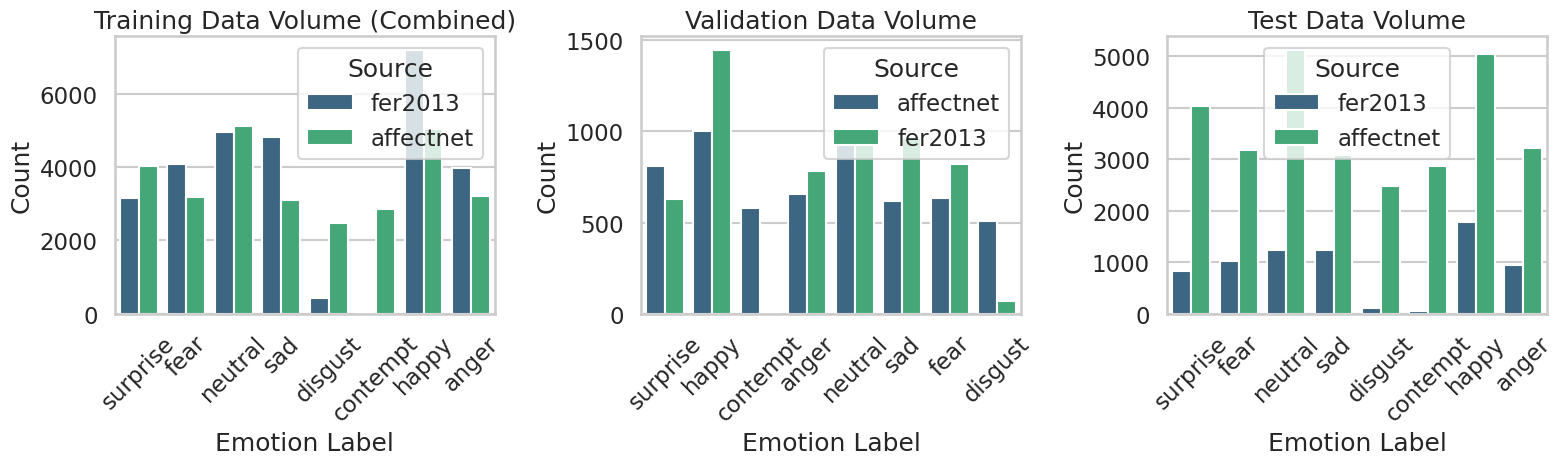

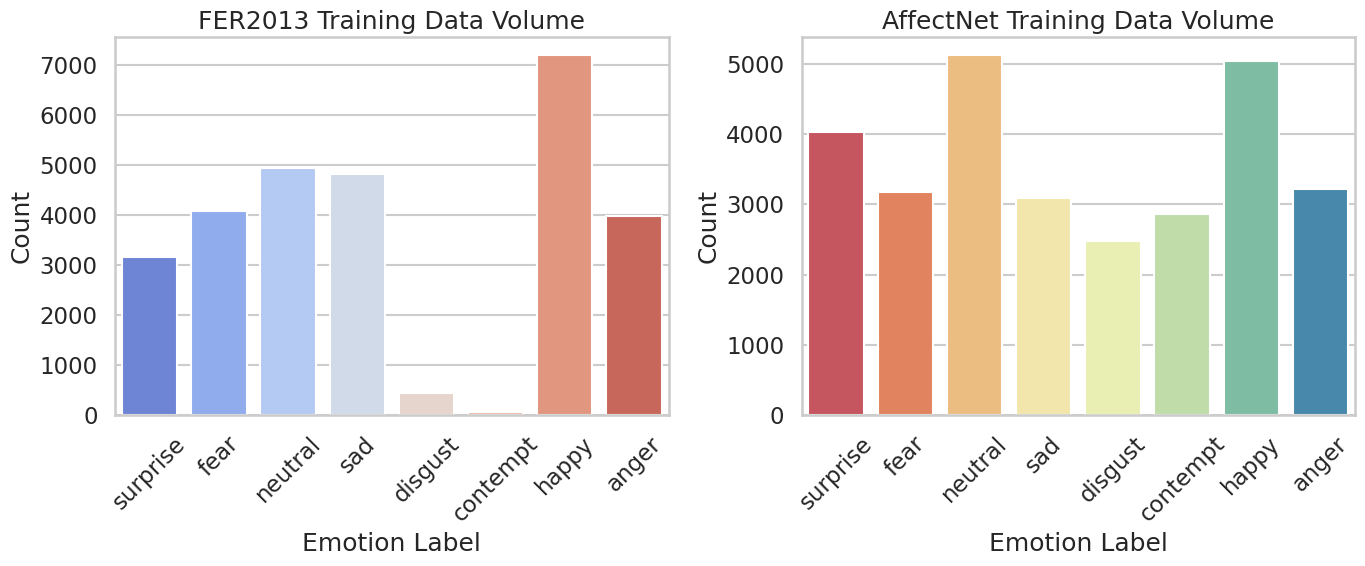

Found 22986 validated image filenames belonging to 8 classes.
Found 23209 validated image filenames belonging to 8 classes.
Steps per epoch: 1445
Found 11549 validated image filenames belonging to 8 classes.
Epoch 1/10
1445/1445 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.3074 - loss: 2.7002

KeyboardInterrupt: 

In [5]:
#refined code 3.0 (lagging)

import os
import glob
import math
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

# -----------------------------------------------------------------------------
# Define key parameters
# -----------------------------------------------------------------------------
img_size = 96         # We'll upscale FER images to 96x96 using bicubic interpolation.
batch_size = 64
epochs = 10            # Adjust epochs as needed.

# -----------------------------------------------------------------------------
# 1. Build a DataFrame from the dataset directory structure
# -----------------------------------------------------------------------------
def build_image_df(root_dir, subfolders=["fer2013", "affectnet"]):
    """
    Scans the given root directory (Train or Test) and returns a DataFrame with columns:
      - filepath: full path to the image file
      - label: the emotion (parent folder name)
      - source: the subfolder name (e.g., fer2013 or affectnet)
    Assumes directory structure: root_dir/emotion/subfolder/image.jpg
    """
    data = []
    emotions = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
    for emotion in emotions:
        emotion_path = os.path.join(root_dir, emotion)
        for sub in subfolders:
            sub_path = os.path.join(emotion_path, sub)
            if os.path.exists(sub_path):
                for img_file in os.listdir(sub_path):
                    if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                        data.append({
                            "filepath": os.path.join(sub_path, img_file),
                            "label": emotion,
                            "source": sub
                        })
    return pd.DataFrame(data)

# -----------------------------------------------------------------------------
# 2. Dataset Paths & DataFrame Creation
# -----------------------------------------------------------------------------
data_dir = "/kaggle/input/custom-fer2013affectnet/Custom_ferAffect2013net"
train_dir = os.path.join(data_dir, "Train")   # Case-sensitive!
test_dir  = os.path.join(data_dir, "Test")

train_df_full = build_image_df(train_dir)
test_df = build_image_df(test_dir)

print("Train DataFrame shape:", train_df_full.shape)
print("Test DataFrame shape:", test_df.shape)

# -----------------------------------------------------------------------------
# 2.1 Standalone Visualization
# -----------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set Seaborn style for a beautiful design.
sns.set(style="whitegrid", context="talk", palette="viridis")

# Assume the following DataFrames exist:
#   - train_df_full: Combined training data (all sources)
#   - train_df: Training set after splitting (could be a subset of train_df_full)
#   - val_df: Validation set
#   - test_df: Test set
#
# Each DataFrame should have at least two columns:
#   - "label": the emotion label
#   - "source": the dataset source ("fer2013" or "affectnet") 
#     (for test_df, if source is not available, we simply show label counts)

# -------------------------------
# Plot 1: Training Data (Combined by Source)
# -------------------------------
plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
sns.countplot(x="label", hue="source", data=train_df_full, palette="viridis")
plt.title("Training Data Volume (Combined)")
plt.xlabel("Emotion Label")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Source")

# -------------------------------
# Plot 2: Validation Data (Combined by Source)
# -------------------------------
plt.subplot(1, 3, 2)
# If the validation DataFrame has a "source" column:
if "source" in val_df.columns:
    sns.countplot(x="label", hue="source", data=val_df, palette="viridis")
    plt.legend(title="Source")
else:
    sns.countplot(x="label", data=val_df, palette="viridis")
plt.title("Validation Data Volume")
plt.xlabel("Emotion Label")
plt.ylabel("Count")
plt.xticks(rotation=45)

# -------------------------------
# Plot 3: Test Data
# -------------------------------
plt.subplot(1, 3, 3)
if "source" in test_df.columns:
    sns.countplot(x="label", hue="source", data=test_df, palette="viridis")
    plt.legend(title="Source")
else:
    sns.countplot(x="label", data=test_df, palette="viridis")
plt.title("Test Data Volume")
plt.xlabel("Emotion Label")
plt.ylabel("Count")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# -------------------------------
# Additional Plots: Separate by Source (Optional)
# -------------------------------
# Create separate DataFrames for FER2013 and AffectNet from train_df_full.
fer_df = train_df_full[train_df_full["source"] == "fer2013"]
aff_df = train_df_full[train_df_full["source"] == "affectnet"]

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.countplot(x="label", data=fer_df, palette="coolwarm")
plt.title("FER2013 Training Data Volume")
plt.xlabel("Emotion Label")
plt.ylabel("Count")
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.countplot(x="label", data=aff_df, palette="Spectral")
plt.title("AffectNet Training Data Volume")
plt.xlabel("Emotion Label")
plt.ylabel("Count")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# 3. Split Training Data into Train & Validation Sets
# -----------------------------------------------------------------------------
train_df, val_df = train_test_split(train_df_full, test_size=0.2, stratify=train_df_full["label"], random_state=42)

# -----------------------------------------------------------------------------
# 4. Source-Specific Augmentation Functions
# -----------------------------------------------------------------------------
def apply_fer_augmentations(img):
    # Gentle augmentations for low-res FER2013 images
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, max_delta=0.1)
    return img

def apply_affectnet_augmentations(img):
    # Stronger augmentations for high-res AffectNet images
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, max_delta=0.3)
    img = tf.image.random_contrast(img, lower=0.8, upper=1.2)
    return img

def augment_based_on_source(img, source):
    # Source-aware augmentation: assume img is a tensor in [0,1]
    if source == "fer2013":
        img = tf.image.rgb_to_grayscale(img)  # Ensure it's grayscale
        img = apply_fer_augmentations(img)
    else:
        img = apply_affectnet_augmentations(img)
    return img

# -----------------------------------------------------------------------------
# 5. Create Separate Generators for FER2013 and AffectNet
# -----------------------------------------------------------------------------
# Split the training DataFrame by source
fer_train_df = train_df[train_df["source"] == "fer2013"]
aff_train_df = train_df[train_df["source"] == "affectnet"]

# For FER2013: load as grayscale with gentle augmentation.
fer_aug_params = {
    "rescale": 1./255,
    "rotation_range": 15,
    "width_shift_range": 0.1,
    "height_shift_range": 0.1,
    "brightness_range": [0.8, 1.2]
}
fer_datagen = ImageDataGenerator(**fer_aug_params)
fer_gen = fer_datagen.flow_from_dataframe(
    dataframe=fer_train_df,
    x_col="filepath",
    y_col="label",
    target_size=(img_size, img_size),
    color_mode="grayscale",
    class_mode="categorical",
    batch_size=32, # 32
    shuffle=True
)

# For AffectNet: load as RGB with stronger augmentation.
aff_aug_params = {
    "rescale": 1./255,
    "rotation_range": 40,
    "brightness_range": [0.5, 1.5],
    "zoom_range": 0.2
}
aff_datagen = ImageDataGenerator(**aff_aug_params)
aff_gen = aff_datagen.flow_from_dataframe(
    dataframe=aff_train_df,
    x_col="filepath",
    y_col="label",
    target_size=(img_size, img_size),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32, # 64
    shuffle=True
)

# Calculate steps for each dataset.
steps_fer = math.ceil(fer_train_df.shape[0] / 32) # 32
steps_aff = math.ceil(aff_train_df.shape[0] / 32) # 64
steps_per_epoch = steps_fer + steps_aff
print(f"Steps per epoch: {steps_per_epoch}")

# -----------------------------------------------------------------------------
# 6. Enhanced Upscaling for FER2013: Bicubic interpolation and channel replication.
# -----------------------------------------------------------------------------
def preprocess_fer_batch(batch):
    # Input: (batch_size, H, W, 1)
    upscaled = tf.image.resize(batch, [img_size, img_size], method="bicubic")
    return tf.repeat(upscaled, repeats=3, axis=-1)  # Now shape: (batch_size, img_size, img_size, 3)

# Wrap the FER generator into a tf.data.Dataset.
def fer_gen_wrapper():
    for batch in fer_gen:
        images, labels = batch
        images = tf.convert_to_tensor(images)
        images = preprocess_fer_batch(images)
        yield (images, labels)

ds_fer = tf.data.Dataset.from_generator(
    fer_gen_wrapper,
    output_signature=(
        tf.TensorSpec(shape=(None, img_size, img_size, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, len(fer_gen.class_indices)), dtype=tf.float32)
    )
)

# For AffectNet, simply convert batches to tensors.
def aff_gen_wrapper():
    for batch in aff_gen:
        images, labels = batch
        images = tf.convert_to_tensor(images)
        yield (images, labels)

ds_aff = tf.data.Dataset.from_generator(
    aff_gen_wrapper,
    output_signature=(
        tf.TensorSpec(shape=(None, img_size, img_size, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, len(aff_gen.class_indices)), dtype=tf.float32)
    )
)

# -----------------------------------------------------------------------------
# 7. Combine the Two Datasets and Optimize Pipeline
# -----------------------------------------------------------------------------
# Both ds_fer and ds_aff already yield batches, so do NOT apply an additional .batch() here.
combined_ds = ds_fer.concatenate(ds_aff)
combined_ds = combined_ds.shuffle(1000).prefetch(tf.data.AUTOTUNE)

# -----------------------------------------------------------------------------
# 8. Compute Class Weights
# -----------------------------------------------------------------------------
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_df["label"]),
    y=train_df["label"]
)
label_to_index = fer_gen.class_indices  # Assumes consistency across sources.
class_weights = {label_to_index[label]: weight for label, weight in zip(np.unique(train_df["label"]), class_weights)}

# -----------------------------------------------------------------------------
# 9. Model Architecture
# -----------------------------------------------------------------------------
input_tensor = Input(shape=(img_size, img_size, 3))
base_model = EfficientNetB0(include_top=False, weights="imagenet", input_tensor=input_tensor)
base_model.trainable = True

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01))(x)
x = Dropout(0.4)(x)
output = Dense(len(fer_gen.class_indices), activation="softmax")(x)
model = Model(inputs=input_tensor, outputs=output)

# -----------------------------------------------------------------------------
# 10. Focal Loss (Optional)
# -----------------------------------------------------------------------------
def focal_loss(gamma=2.0, alpha=0.25):
    def loss_fn(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
        cross_entropy = -y_true * tf.math.log(y_pred)
        loss = alpha * tf.math.pow(1 - y_pred, gamma) * cross_entropy
        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))
    return loss_fn

loss_function = focal_loss()  # Or "categorical_crossentropy" if preferred

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=loss_function,
    metrics=["accuracy"]
)

# -----------------------------------------------------------------------------
# 11. Training Configuration & Callbacks
# -----------------------------------------------------------------------------
def cosine_annealing(epoch, lr):
    initial_lr = 1e-4
    return initial_lr * (1 + math.cos(math.pi * epoch / epochs)) / 2

callbacks = [
    EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True),
    ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_accuracy", mode="max"),
    LearningRateScheduler(cosine_annealing),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6)
]

# Create a validation dataset from val_df using a similar pipeline for FER images.
val_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    dataframe=val_df,
    x_col="filepath",
    y_col="label",
    target_size=(img_size, img_size),
    color_mode="grayscale",
    batch_size=batch_size,
    shuffle=False
)
def val_gen_wrapper():
    for batch in val_gen:
        images, labels = batch
        images = tf.convert_to_tensor(images)
        images = preprocess_fer_batch(images)
        yield (images, labels)

ds_val = tf.data.Dataset.from_generator(
    lambda: val_gen_wrapper(),
    output_signature=(
        tf.TensorSpec(shape=(None, img_size, img_size, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, len(val_gen.class_indices)), dtype=tf.float32)
    )
).prefetch(tf.data.AUTOTUNE)

start_time = time.time()
history = model.fit(
    combined_ds,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=ds_val,
    class_weight=class_weights,
    callbacks=callbacks
)
end_time = time.time()
print(f"Training Time: {end_time - start_time:.2f} seconds")

# Save the trained model
model.save("final_emotion_model.keras")

# -----------------------------------------------------------------------------
# 12. Evaluation & Visualization on Test Data
# -----------------------------------------------------------------------------
# Standardize test set: load as grayscale then convert to 3 channels.
test_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=lambda x: np.repeat(x, 3, axis=-1)
)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="filepath",
    y_col="label",
    target_size=(img_size, img_size),
    color_mode="grayscale",
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False
)

loss, accuracy = model.evaluate(test_generator)
print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

predictions = np.argmax(model.predict(test_generator), axis=-1)
true_labels = test_generator.classes

print(f"\nWeighted F1-Score: {f1_score(true_labels, predictions, average='weighted'):.4f}")

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(true_labels, predictions), 
            annot=True, fmt="d", 
            cmap="Blues",
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=test_generator.class_indices.keys()))

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Accuracy Curves")

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Loss Curves")
plt.show()

# -----------------------------------------------------------------------------
# 13. Testing Saved Model on Individual Test Images
# -----------------------------------------------------------------------------
saved_model = keras.models.load_model("final_emotion_model.keras", compile=False)
class_labels = list(test_generator.class_indices.keys())

for class_name in class_labels:
    class_path = os.path.join(test_dir, class_name)
    if os.path.exists(class_path):
        test_images = os.listdir(class_path)
        print(f"\nTesting images for class: {class_name}")
        for img_name in test_images[:5]:
            img_path = os.path.join(class_path, img_name)
            # Load as grayscale then convert to RGB.
            img = keras.preprocessing.image.load_img(img_path, target_size=(img_size, img_size), color_mode="grayscale")
            img_array = keras.preprocessing.image.img_to_array(img) / 255.0
            img_array = np.repeat(img_array, 3, axis=-1)
            img_array = np.expand_dims(img_array, axis=0)
            
            prediction = saved_model.predict(img_array)
            predicted_class = class_labels[np.argmax(prediction)]
            confidence = np.max(prediction)
            
            plt.imshow(img_array[0].astype("float32"))
            plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence:.2f}")
            plt.axis("off")
            plt.show()

In [13]:
# Version 5.0

import os
import glob
import math
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

# =============================================================================
# Define key parameters
# =============================================================================
img_size = 96         # We upscale FER images to 96x96
batch_size = 64
epochs = 10

# =============================================================================
# Learning Rate Finder Callback (Fixed)
# =============================================================================
class LRFinder(tf.keras.callbacks.Callback):
    def __init__(self, min_lr=1e-6, max_lr=1e-2, steps=100):
        super(LRFinder, self).__init__()
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.steps = steps
        self.lrs = []
        self.losses = []
        
    def on_train_begin(self, logs=None):
        # Use optimizer.learning_rate (compatible with LossScaleOptimizer)
        self.original_lr = tf.keras.backend.get_value(self.model.optimizer.learning_rate)
        tf.keras.backend.set_value(self.model.optimizer.learning_rate, self.min_lr)
        self.optimizer = self.model.optimizer
    
    def on_batch_end(self, batch, logs=None):
        lr = tf.keras.backend.get_value(self.optimizer.learning_rate)
        self.lrs.append(lr)
        self.losses.append(logs.get('loss'))
        new_lr = lr * (self.max_lr / self.min_lr) ** (1/self.steps)
        tf.keras.backend.set_value(self.optimizer.learning_rate, new_lr)
        if batch >= self.steps:
            self.model.stop_training = True
            
    def on_train_end(self, logs=None):
        tf.keras.backend.set_value(self.optimizer.learning_rate, self.original_lr)

# =============================================================================
# 1. Build a DataFrame from the dataset directory structure
# =============================================================================
def build_image_df(root_dir, subfolders=["fer2013", "affectnet"]):
    """
    Scans the given root directory (Train or Test) and returns a DataFrame with columns:
      - filepath: full path to the image file
      - label: the emotion (parent folder name)
      - source: the subfolder name (e.g., fer2013 or affectnet)
    Assumes directory structure: root_dir/emotion/subfolder/image.jpg
    """
    data = []
    emotions = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
    for emotion in emotions:
        emotion_path = os.path.join(root_dir, emotion)
        for sub in subfolders:
            sub_path = os.path.join(emotion_path, sub)
            if os.path.exists(sub_path):
                for img_file in os.listdir(sub_path):
                    if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                        data.append({
                            "filepath": os.path.join(sub_path, img_file),
                            "label": emotion,
                            "source": sub
                        })
    return pd.DataFrame(data)

# =============================================================================
# 2. Dataset Paths & DataFrame Creation
# =============================================================================
data_dir = "/kaggle/input/custom-fer2013affectnet/Custom_ferAffect2013net"
train_dir = os.path.join(data_dir, "Train")   # Case-sensitive!
test_dir  = os.path.join(data_dir, "Test")

train_df_full = build_image_df(train_dir)
test_df = build_image_df(test_dir)

print("Train DataFrame shape:", train_df_full.shape)
print("Test DataFrame shape:", test_df.shape)

# =============================================================================
# X. Visualization Code for DataFrames
# =============================================================================

import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style for a beautiful design.
sns.set(style="whitegrid", context="talk", palette="viridis")

# Plot 1: Training Data (Combined by Source)
plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
sns.countplot(x="label", hue="source", data=train_df_full, palette="viridis")
plt.title("Training Data Volume (Combined)")
plt.xlabel("Emotion Label")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Source")

# Plot 2: Validation Data (Combined by Source)
plt.subplot(1, 3, 2)
if "source" in val_df.columns:
    sns.countplot(x="label", hue="source", data=val_df, palette="viridis")
    plt.legend(title="Source")
else:
    sns.countplot(x="label", data=val_df, palette="viridis")
plt.title("Validation Data Volume")
plt.xlabel("Emotion Label")
plt.ylabel("Count")
plt.xticks(rotation=45)

# Plot 3: Test Data
plt.subplot(1, 3, 3)
if "source" in test_df.columns:
    sns.countplot(x="label", hue="source", data=test_df, palette="viridis")
    plt.legend(title="Source")
else:
    sns.countplot(x="label", data=test_df, palette="viridis")
plt.title("Test Data Volume")
plt.xlabel("Emotion Label")
plt.ylabel("Count")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Additional Plots: Separate by Source (Optional)
fer_df = train_df_full[train_df_full["source"] == "fer2013"]
aff_df = train_df_full[train_df_full["source"] == "affectnet"]

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.countplot(x="label", data=fer_df, palette="coolwarm")
plt.title("FER2013 Training Data Volume")
plt.xlabel("Emotion Label")
plt.ylabel("Count")
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.countplot(x="label", data=aff_df, palette="Spectral")
plt.title("AffectNet Training Data Volume")
plt.xlabel("Emotion Label")
plt.ylabel("Count")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


# =============================================================================
# 3. Split Training Data into Train & Validation Sets
# =============================================================================
train_df, val_df = train_test_split(train_df_full, test_size=0.2, stratify=train_df_full["label"], random_state=42)

# =============================================================================
# 4. Source-Specific Augmentation Functions
# =============================================================================
def apply_fer_augmentations(img):
    # Gentle augmentations for low-res FER2013 images
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, max_delta=0.1)
    return img

def apply_affectnet_augmentations(img):
    # Stronger augmentations for high-res AffectNet images
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, max_delta=0.3)
    img = tf.image.random_contrast(img, lower=0.8, upper=1.2)
    return img

def augment_based_on_source(img, source):
    # Source-aware augmentation: assume img is a tensor in [0,1]
    if source == "fer2013":
        img = tf.image.rgb_to_grayscale(img)  # Ensure it's grayscale
        img = apply_fer_augmentations(img)
    else:
        img = apply_affectnet_augmentations(img)
    return img

# =============================================================================
# 5. Create Separate Generators for FER2013 and AffectNet
# =============================================================================
# Split the training DataFrame by source
fer_train_df = train_df[train_df["source"] == "fer2013"]
aff_train_df = train_df[train_df["source"] == "affectnet"]

classes = sorted(train_df_full["label"].unique())

# For FER2013: load as grayscale with gentle augmentation.
fer_aug_params = {
    "rescale": 1./255,
    "rotation_range": 15,
    "width_shift_range": 0.1,
    "height_shift_range": 0.1,
    "brightness_range": [0.8, 1.2]
}
fer_datagen = ImageDataGenerator(**fer_aug_params)
fer_gen = fer_datagen.flow_from_dataframe(
    dataframe=fer_train_df,
    x_col="filepath",
    y_col="label",
    target_size=(img_size, img_size),
    color_mode="grayscale",
    class_mode="categorical",
    classes=classes,
    batch_size=32,
    shuffle=True
)

# For AffectNet: load as RGB with stronger augmentation.
aff_aug_params = {
    "rescale": 1./255,
    "rotation_range": 40,
    "brightness_range": [0.5, 1.5],
    "zoom_range": 0.2
}
aff_datagen = ImageDataGenerator(**aff_aug_params)
aff_gen = aff_datagen.flow_from_dataframe(
    dataframe=aff_train_df,
    x_col="filepath",
    y_col="label",
    target_size=(img_size, img_size),
    color_mode="rgb",
    class_mode="categorical",
    classes=classes,
    batch_size=32,
    shuffle=True
)

# Calculate steps for each dataset.
steps_fer = math.ceil(fer_train_df.shape[0] / 32)
steps_aff = math.ceil(aff_train_df.shape[0] / 32)
steps_per_epoch = steps_fer + steps_aff
print(f"Steps per epoch: {steps_per_epoch}")

# =============================================================================
# 6. Enhanced Upscaling for FER2013: Bicubic interpolation and channel replication.
# =============================================================================
def preprocess_fer_batch(batch):
    # Input: (batch_size, H, W, 1)
    upscaled = tf.image.resize(batch, [img_size, img_size], method="bicubic")
    return tf.repeat(upscaled, repeats=3, axis=-1)  # Now shape: (batch_size, img_size, img_size, 3)

# Wrap the FER generator into a tf.data.Dataset.
def fer_gen_wrapper():
    for batch in fer_gen:
        images, labels = batch
        images = tf.convert_to_tensor(images)
        images = preprocess_fer_batch(images)
        yield (images, labels)

ds_fer = tf.data.Dataset.from_generator(
    fer_gen_wrapper,
    output_signature=(
        tf.TensorSpec(shape=(None, img_size, img_size, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, len(fer_gen.class_indices)), dtype=tf.float32)
    )
)

# For AffectNet, simply convert batches to tensors.
def aff_gen_wrapper():
    for batch in aff_gen:
        images, labels = batch
        images = tf.convert_to_tensor(images)
        yield (images, labels)

ds_aff = tf.data.Dataset.from_generator(
    aff_gen_wrapper,
    output_signature=(
        tf.TensorSpec(shape=(None, img_size, img_size, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, len(aff_gen.class_indices)), dtype=tf.float32)
    )
)

# =============================================================================
# 7. Combine the Two Datasets and Optimize Pipeline
# =============================================================================
# Both ds_fer and ds_aff already yield batches, so do NOT apply an additional .batch() here.
combined_ds = ds_fer.concatenate(ds_aff)
combined_ds = combined_ds.shuffle(1000).prefetch(tf.data.AUTOTUNE)

# =============================================================================
# 8. Compute Class Weights
# =============================================================================
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_df["label"]),
    y=train_df["label"]
)
label_to_index = fer_gen.class_indices  # Assumes consistency across sources.
class_weights = {label_to_index[label]: weight for label, weight in zip(np.unique(train_df["label"]), class_weights)}

# =============================================================================
# 9. Model Architecture
# =============================================================================
# (Optional) Enable mixed precision
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

input_tensor = Input(shape=(img_size, img_size, 3))
base_model = EfficientNetB0(include_top=False, weights="imagenet", input_tensor=input_tensor)
base_model.trainable = True

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01))(x)
x = Dropout(0.4)(x)
output = Dense(len(classes), activation="softmax", dtype="float32")(x)
model = Model(inputs=input_tensor, outputs=output)

# =============================================================================
# 10. Focal Loss (Optional)
# =============================================================================
def focal_loss(gamma=2.0, alpha=0.25):
    def loss_fn(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
        cross_entropy = -y_true * tf.math.log(y_pred)
        loss = alpha * tf.math.pow(1 - y_pred, gamma) * cross_entropy
        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))
    return loss_fn

loss_function = focal_loss()  # Or use "categorical_crossentropy"

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=loss_function,
    metrics=["accuracy"]
)

# =============================================================================
# 11. Training Configuration & Callbacks
# =============================================================================

def cosine_annealing(epoch, lr):
    initial_lr = 1e-4
    return initial_lr * (1 + math.cos(math.pi * epoch / epochs)) / 2

callbacks = [
    EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True),
    ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_accuracy"),
    LearningRateScheduler(cosine_annealing),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6)
]

# Create a validation dataset from val_df using a similar pipeline for FER images.
val_fer = val_df[val_df["source"] == "fer2013"]
val_aff = val_df[val_df["source"] == "affectnet"]

val_fer_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    dataframe=val_fer,
    x_col="filepath",
    y_col="label",
    target_size=(img_size, img_size),
    color_mode="grayscale",
    classes=classes,
    batch_size=batch_size,
    shuffle=False
)
val_aff_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    dataframe=val_aff,
    x_col="filepath",
    y_col="label",
    target_size=(img_size, img_size),
    color_mode="rgb",
    classes=classes,
    batch_size=batch_size,
    shuffle=False
)
def val_gen_wrapper():
    for batch in val_fer_gen:
        images, labels = batch
        images = tf.convert_to_tensor(images)
        images = preprocess_fer_batch(images)
        yield (images, labels)
    for batch in val_aff_gen:
        yield batch

ds_val = tf.data.Dataset.from_generator(
    lambda: val_gen_wrapper(),
    output_signature=(
        tf.TensorSpec(shape=(None, img_size, img_size, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, len(classes)), dtype=tf.float32)
    )
).prefetch(tf.data.AUTOTUNE)

start_time = time.time()
history = model.fit(
    combined_ds,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=ds_val,
    class_weight=class_weights,
    callbacks=callbacks
)
end_time = time.time()
print(f"Training Time: {end_time - start_time:.2f} seconds")

# Save the trained model
model.save("final_emotion_model.keras")

# =============================================================================
# 12. Evaluation & Visualization on Test Data
# =============================================================================
# Standardize test set: load as grayscale then convert to 3 channels.
test_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=lambda x: np.repeat(x, 3, axis=-1)
)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="filepath",
    y_col="label",
    target_size=(img_size, img_size),
    color_mode="grayscale",
    class_mode="categorical",
    classes=classes,
    batch_size=batch_size,
    shuffle=False
)

loss, accuracy = model.evaluate(test_generator)
print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

predictions = np.argmax(model.predict(test_generator), axis=-1)
true_labels = test_generator.classes

print(f"\nWeighted F1-Score: {f1_score(true_labels, predictions, average='weighted'):.4f}")

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(true_labels, predictions), 
            annot=True, fmt="d", 
            cmap="Blues",
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=test_generator.class_indices.keys()))

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Accuracy Curves")

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Loss Curves")
plt.show()

# =============================================================================
# 13. Testing Saved Model on Individual Test Images
# =============================================================================
saved_model = keras.models.load_model("final_emotion_model.keras", compile=False)
class_labels = list(test_generator.class_indices.keys())

for class_name in class_labels:
    class_path = os.path.join(test_dir, class_name)
    if os.path.exists(class_path):
        test_images = os.listdir(class_path)
        print(f"\nTesting images for class: {class_name}")
        for img_name in test_images[:5]:
            img_path = os.path.join(class_path, img_name)
            # Load as grayscale then convert to RGB.
            img = keras.preprocessing.image.load_img(img_path, target_size=(img_size, img_size), color_mode="grayscale")
            img_array = keras.preprocessing.image.img_to_array(img) / 255.0
            img_array = np.repeat(img_array, 3, axis=-1)
            img_array = np.expand_dims(img_array, axis=0)
            
            prediction = saved_model.predict(img_array)
            predicted_class = class_labels[np.argmax(prediction)]
            confidence = np.max(prediction)
            
            plt.imshow(img_array[0].astype("float32"))
            plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence:.2f}")
            plt.axis("off")
            plt.show()


Train DataFrame shape: (57744, 3)
Test DataFrame shape: (36274, 3)
Found 22986 validated image filenames belonging to 8 classes.
Found 23209 validated image filenames belonging to 8 classes.
Steps per epoch: 1445

Finding optimal learning rate...


AttributeError: 'str' object has no attribute 'name'